This notebook shows how to build a CNN with inception layers similar to what we used in the army signal classification challenge. Here we build a model to classify handwritten digits from the mnist dataset. Since we have less data here we use a 'relatively small' model with 362,634 trainable parameters. After 16 epochs it achieved an accuracy of 99.43%.

In [1]:
from scipy.misc import imread
import numpy as np
from keras.models import load_model, Model
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Dense, LSTM
import keras
from keras.utils import plot_model
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder


/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = np.load('mnist.npz')

# Or download using
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_test, x_train, y_train, y_test = data['x_test'], data['x_train'], data['y_train'], data['y_test']

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
def inception(input_img, fs=[64,64,64,64,64],height = 2, size = [8,4],  with_residual=False,data_format='channels_last'):
    tower_1 = Conv2D(filters=fs[0], kernel_size=[1, 1], padding='same',activation='relu', data_format=data_format)(input_img)
    tower_2 = Conv2D(filters=fs[2], kernel_size=1, padding='same',activation='relu', data_format=data_format)(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size= size[0], padding='same',activation='relu', data_format=data_format)(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=1, padding='same',activation='relu', data_format=data_format)(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size= size[1], padding='same',activation='relu', data_format=data_format)(tower_3)
    tower_4 = MaxPooling2D(3, strides=1, padding='same', data_format=data_format)(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same',activation='relu', data_format=data_format)(tower_4)
    
    if len(size) == 3:
        tower_5 = Conv2D(filters=fs[2], kernel_size=1, padding='same',activation='relu', data_format=data_format)(input_img)
        tower_5 = Conv2D(filters=fs[3], kernel_size= size[2], padding='same',activation='relu', data_format=data_format)(tower_5)
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4, tower_5], axis = 3)
    else:
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output

def googleNet(x, data_format='channels_last', num_layers = [1,1,1,1], num_classes=10):
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 128, kernel_size=7, strides=1, data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D(2, strides=2, padding='same', data_format=data_format)(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 192, kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu', data_format=data_format)(x)
    x = MaxPooling2D(2, strides=2, padding='same', data_format=data_format)(x)

    for dep in range(num_layers[1]):
        x = inception(x, size=[2,4,8], fs=[32,32,32,32,32], with_residual=True)
        
        
# Since we have less data we use a smaller model

#     x = MaxPooling2D(2, strides=2, padding='same', data_format=data_format)(x)
#     for dep in range(num_layers[2]):
#         x = inception(x, size=[8,4], fs=[32,32,32,32,32], with_residual=True)
#     x = MaxPooling2D(2, strides=2, padding='same', data_format=data_format)(x)
    for dep in range(num_layers[3]):
        x = inception(x, size=[8,4], fs=[32,32,32,32,32])

        
    x = Dropout(0.6)(x)
    x = Flatten()(x)


    x = Dense(num_classes, activation='softmax')(x)
    return x
in_shp = (28, 28)
input_img = Input(shape=in_shp)
out = googleNet(input_img,data_format='channels_last', num_classes=10)
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  6400        reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 128)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

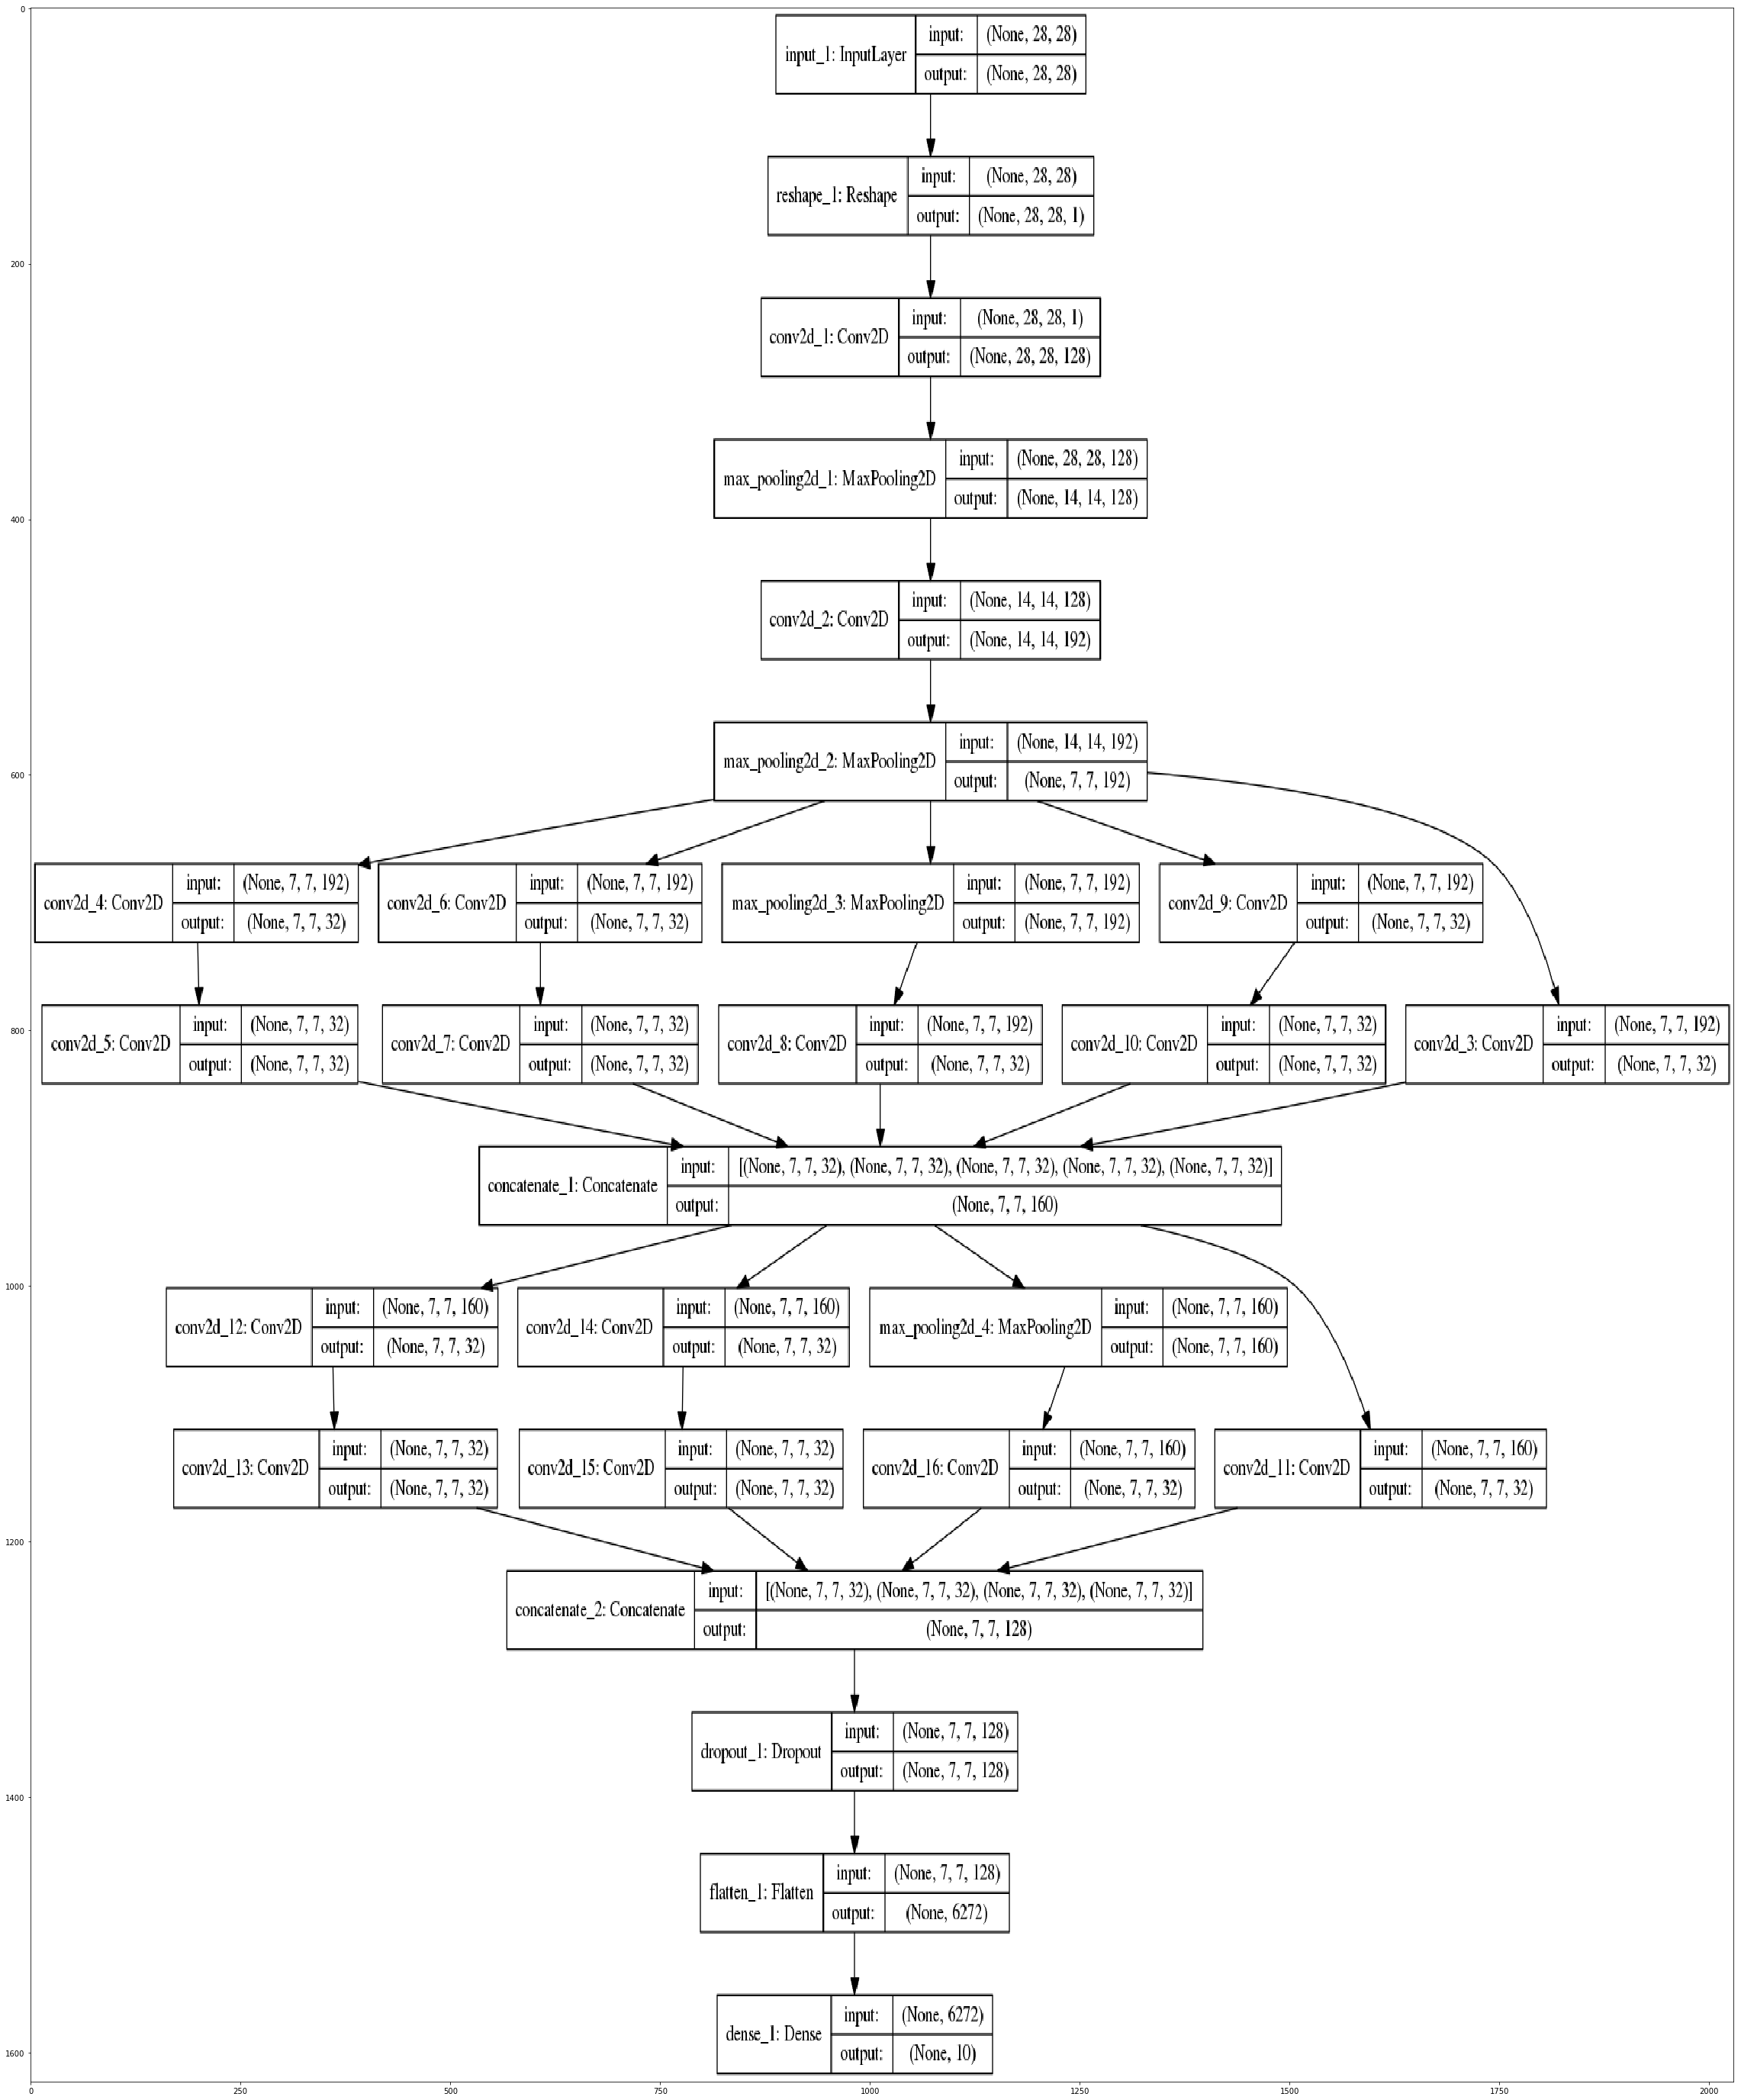

In [24]:
plot_model(model, to_file='model.png', show_shapes = True)

figure(figsize = (40,50))
img = mpimg.imread('model.png')
plt.imshow(img, aspect='auto')
plt.show()

In [7]:
def make_generator(data,labels,batch_size):
    # takes data and batch size and returns a gernerator
    
    steps_per_epoch = data.shape[0] // batch_size
    while True:
        idx = np.random.permutation(data.shape[0])

        data = data[idx]
        labels = labels[idx]
        
        ##### can do data augmentation here #####
        
        
        ######################################
        
        start = 0
        
        for i in range(steps_per_epoch):
            yield data[start:start+batch_size], labels[start:start+batch_size]
            start += batch_size
    

train_batch_size, number_of_epochs = 512, 20
val_batch_size = 512


tsteps = x_train.shape[0] // train_batch_size
vsteps = x_test.shape[0] // val_batch_size

In [8]:
def to_one_hot(labels):
    l = labels.shape[0]
    res = np.zeros((l, 10))
    for i in range(l):
        res[i,labels[i]] = 1
    
    return res
    

y_test_one_hot = to_one_hot(y_test)
y_train_one_hot = to_one_hot(y_train)


val_batches = make_generator(x_test, y_test_one_hot, val_batch_size)
train_batches = make_generator(x_train, y_train_one_hot, train_batch_size)



In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath = 'convmodrecnets_CNN2_0.5.wts.h5'


history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
     callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='auto')
     ]) 

print("Done")

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=117, verbose=2, validation_data=<generator..., validation_steps=19, callbacks=[<keras.ca..., epochs=20)`
  


Epoch 1/20
 - 5s - loss: 0.0357 - val_loss: 0.0313
Epoch 2/20
 - 4s - loss: 0.0295 - val_loss: 0.0252
Epoch 3/20
 - 4s - loss: 0.0269 - val_loss: 0.0213
Epoch 4/20
 - 4s - loss: 0.0261 - val_loss: 0.0251
Epoch 5/20
 - 4s - loss: 0.0213 - val_loss: 0.0327
Epoch 6/20
 - 4s - loss: 0.0220 - val_loss: 0.0208
Epoch 7/20
 - 4s - loss: 0.0201 - val_loss: 0.0228
Epoch 8/20
 - 4s - loss: 0.0209 - val_loss: 0.0223
Epoch 9/20
 - 4s - loss: 0.0172 - val_loss: 0.0196
Epoch 10/20
 - 4s - loss: 0.0161 - val_loss: 0.0268
Epoch 11/20
 - 4s - loss: 0.0171 - val_loss: 0.0295
Epoch 12/20
 - 4s - loss: 0.0144 - val_loss: 0.0248
Epoch 13/20
 - 4s - loss: 0.0163 - val_loss: 0.0248
Epoch 14/20
 - 4s - loss: 0.0129 - val_loss: 0.0264
Epoch 15/20
 - 4s - loss: 0.0170 - val_loss: 0.0268
Epoch 16/20
 - 4s - loss: 0.0166 - val_loss: 0.0280
Done


In [17]:
model = load_model(filepath)
preds = model.predict(x_test)
preds = np.argmax(preds, axis=1)
misclassified = np.where(preds != y_test)

In [18]:
print('Accuracy:', 1-len(misclassified[0])/ (y_test.shape[0]))

Accuracy: 0.9943


In [19]:
model.save('mnist_model.h5')